# Iteration 20: Link models (2) stage 2

## Plain English Summary

This is the second step of linking the Acute Stroke Unit (ASU) and Rehab Unit (RU) models.  Here we enable transfers between models and also create a script to run both models (completed in a second prompt that does not affect model logic).

**Steps:**

1. Modify the ASU class to hold an instance of the RU. Prepare acute treatment functions to transfer patients labelled as "Rehab".
2. Modify all ASU acute treatment functions to transfer patients to the RU if a patient is labelled "Rehab" (This notebook)

> NOTE: The new constructor for the ASU class means that all testing functions and scripts must now be updated.

## Notebook imports

In [7]:
from IPython.display import Markdown, display, HTML
import math
import statistics
from sim_tools.distributions import Lognormal

## LLM Prompt 1 <a class="anchor" id="llm_prompt"></a>

In [8]:
display(Markdown("../01_perplexity/inputs/20_iteration.md"))

append new code to the end of four methods in `AcuteStrokeUnit` postfixed with "acute_treatment": if `post_asu_destination` is "Rehab" then a.) incrememnt `rehab_unit.occupancy` and then b.) call the `rehab_unit` function with the same patient_type as a simpy process.  For example, `stroke_patient_generator` called `rehab_unit.stroke_rehab_treatment`. Do not pass any parameters. The code should be located after "self.occupancy -= 1". Do not use the yield keyword.  

Display all code in the  `AcuteStrokeUnit class including all treatment and patient generator methods.




## LLM Prompt 2 (for creating a script to run both models)

In [9]:
display(Markdown("../01_perplexity/inputs/20a_iteration.md"))

Combine the two scripts below create a new single script that follows these steps:

1. create an instance of `Experiment`
2. create an instance of a simpy environment
3. create an instance RehabilitationUnit 
4. create an instance of AcuteStrokeUnit. Pass the RehabilitationUnit as a parameter
5. initialise the four methods postfixed with "generator" in AcuteStrokeUnit  as simpy processes
6. initialise the three methods postfixed with "generator" in RehabilitationUnit  simpy processes
7. initialise the audit of rehab occupancy as a simpy process. Use an interval of 1 day.  Pass in env
8. initialise the audit of the AcuteStrokeUnit occupancy as a simpy process. Use an interval of 1 day.
9. run the model for the default run length in the experiment * 50
10. use `calculate_occupancy_frequencies` to calculate occupancy frequencies of both the AcuteStrokeUnit and the rehab occupancy
11. use `calculate_prob_delay` to calculate the probability of delay for AcuteStrokeUnit and rehab  
12. use `prob_delay_plot` to display a prob of delay plot for AcuteStrokeUnit and rehab.  Use appropriate x_label values for the AcuteStrokeUnit and rehab unit

Only show the code in the script. Do no modify the functions or classes used.

```python
# Create an instance of the Experiment class with default parameters and trace set to False
default_experiment_params = Experiment()

# Create the simulation environment and AcuteStrokeUnit instance with the Experiment parameters
env = simpy.Environment()

## MODIFIED BY TESTER
#  create instance of RU, but we do not run the model at this stage
rehab_unit = RehabilitationUnit(env, default_experiment_params)
##

acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)

# Start the patient generators for each type of patient in the AcuteStrokeUnit instance
env.process(acu_experiment.stroke_patient_generator())
env.process(acu_experiment.tia_patient_generator())
env.process(acu_experiment.neuro_patient_generator())
env.process(acu_experiment.other_patient_generator())

# Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
env.process(audit_acute_occupancy(1, acu_experiment, default_experiment_params))

# Run the simulation until the specified run length in the Experiment parameters
# modified by tester - run length * 10
env.run(until=default_experiment_params.run_length * 10)

# Calculate occupancy frequencies and plot the relative frequency distribution
relative_freq, cumulative_freq, unique_vals = calculate_occupancy_frequencies(default_experiment_params.asu_occupancy)

# Calculate probability of delay and plot the step chart
prob_delay = calculate_prob_delay(relative_freq, cumulative_freq)
prob_delay_plot(prob_delay, unique_vals)
```

```python
# 1. Create an experiment
experiment = Experiment()

# 2. Create an instance of a simpy environment
env = simpy.Environment()

# 3. Create an instance of RehabilitationUnit
rehab_unit = RehabilitationUnit(env, experiment)

# 4. Initialize the patient generators as simpy processes
env.process(rehab_unit.stroke_patient_generator())
env.process(rehab_unit.neuro_patient_generator())
env.process(rehab_unit.other_patient_generator())

# 5. Initialize the audit of rehab occupancy as a simpy process with an interval of 1 day
env.process(audit_rehab_occupancy(env, 1, rehab_unit, experiment))

# 6. Run the model for the default run length in the experiment * 10
env.run(until=experiment.run_length * 10)

# 7. Calculate occupancy frequencies of the rehab occupancy
relative_frequency, cumulative_frequency, unique_values = calculate_occupancy_frequencies(experiment.rehab_occupancy)

# 8. Display an occupancy plot for the rehab unit
occupancy_plot(relative_frequency, unique_values, x_label="No. of people in rehab")

# 9. Calculate the probability of delay for rehab
prob_delay = calculate_prob_delay(relative_frequency, cumulative_frequency)

# 10. Display a probability of delay plot for rehab
prob_delay_plot(prob_delay, unique_values, x_label="No. rehab beds available")

```

## Date and time of input to LLM

> 0800 16th July 2024

## Observations on the LLM Output

* This was a difficult iteration for the LLM, mainly because the model has deviated fairly significantly from Stage 1.
* Prompt 1 appeared to work but an error in calculating ASU occupancy was observed by tester - occupancy is incremented in the `patient-generator` function and decremented in the `acute_treatment` function but the LLM was additionally decrementing in each of the treatment functions which are called in `acute_treatment`.
* A second prompt asked for these to be removed
* A third prompt made the plotting function titles more generic.

* Prompt 2 had to be modified to run the models, as ASU and Rehab Unit have different structures and run methods.
* This required 2 additional prompts.
* (TOTAL OF SIX PROMPTS)
* The output for Rehab was not as expected when both models were run together - again this was because of how occupancy was being calculated. As per the prompts, patients were passed from ASU to the appropriate rehab treatment function if labelled 'Rehab'. This meant they bipassed `rehab_treatment` which calls each treatment function, and decrements occupancy.
* This was manually adjusted to avoid introducing new issues - such that `rehab_treatment` is called with patient_type as a parameter.
* Additionally, other manual additions were added for debugging.
* The model continues to calculate parameters when the lognormal function is used in the rehab model. Ideally the rehab and ASU models would be structured consistently, with the rehab model either modifying and using the existing `PatientType` class, or creating a rehab patient class. The decision was made to let the LLM continue to make its own choices, as long as it works, even where redundant, inconsistent, or repetitive code is used. This is for the purpose of examining challenges introduced by the LLM to the model build process, such as additional debugging processes. The parameter conversion used in rehab is added to `test_lognormal_moments` for now but a new function may be introduced at a later iteration. 

## Sources reported by the LLM

* None reported 

## Code carried over from iteration 13

We carry over:

* `Experiment` and `PatientType`
*  Occupancy post processing code
*  Probability of delay post processing code

## Model code <a class="anchor" id="model_code"></a>

### Imports

In [10]:
import simpy
import numpy as np
import math
import matplotlib.pyplot as plt

### Experiment class and Patient Class

In [11]:
class Experiment:
    def __init__(self, params=None):
        default_params = {
            'run_length': 5 * 365,
            'trace': False,
            'acute_audit_interval': 1,  # Default to 1 day
            'rehab_audit_interval': 1,  # Default to 1 day
            'rehab_stroke_iat': 21.8,
            'rehab_neuro_iat': 31.7,
            'rehab_other_iat': 28.6,
            # New parameters for RehabilitationUnit
            'rehab_stroke_esd_los_mean': 30.3,
            'rehab_stroke_esd_los_std': 23.1,
            'rehab_stroke_other_los_mean': 28.4,
            'rehab_stroke_other_los_std': 27.2,
            'rehab_complex_neuro_los_mean': 27.6,
            'rehab_complex_neuro_los_std': 28.4,
            'rehab_other_los_mean': 16.1,
            'rehab_other_los_std': 14.1,
            'rehab_stroke_post_destination_probs': [0.4, 0.6],
            'rehab_complex_neuro_post_destination_probs': [0.09, 0.91],
            'rehab_other_post_destination_probs': [0.12, 0.88],
            'patient_types': {
                'Stroke': {
                    'interarrival_time': 1.2,
                    'post_asu_probabilities': [0.24, 0.13, 0.63],
                    'los_params': {'Rehab': (7.4, 8.6), 'ESD': (4.6, 4.8), 'Other': (7.0, 8.7)}
                },
                'TIA': {
                    'interarrival_time': 9.3,
                    'post_asu_probabilities': [0.01, 0.01, 0.98],
                    'los_params': (1.8, 5.0)
                },
                'Complex Neurological': {
                    'interarrival_time': 3.6,
                    'post_asu_probabilities': [0.11, 0.05, 0.84],
                    'los_params': (4.0, 5.0)
                },
                'Other': {
                    'interarrival_time': 3.2,
                    'post_asu_probabilities': [0.05, 0.10, 0.85],
                    'los_params': (3.8, 5.2)
                }
            }
        }

        if params is None:
            self.params = default_params
        else:
            self.params = self.merge_params(default_params, params)

        self.asu_occupancy = []  # Initialize the list to store ASU occupancy
        self.rehab_occupancy = []  # Initialize the list to store rehab occupancy

    def merge_params(self, default, new):
        merged = default.copy()
        for key, value in new.items():
            if isinstance(value, dict) and key in merged:
                merged[key] = self.merge_params(merged[key], value)
            else:
                merged[key] = value
        return merged

    def audit_acute_occupancy(self, env, acute_audit_interval, asu):
        while True:
            yield env.timeout(acute_audit_interval)
            self.asu_occupancy.append(asu.occupancy)

    def audit_rehab_occupancy(self, env, rehab_audit_interval, rehab_unit):
        while True:
            yield env.timeout(rehab_audit_interval)
            self.rehab_occupancy.append(rehab_unit.occupancy)


class PatientType:
    def __init__(self, name, interarrival_time, post_asu_probabilities, los_params):
        self.name = name
        self.interarrival_time = interarrival_time
        self.count = 0
        self.rng = np.random.default_rng()
        self.post_asu_probabilities = post_asu_probabilities
        self.los_params = los_params

    def generate_interarrival_time(self):
        return self.rng.exponential(self.interarrival_time)

    def sample_post_asu_destination(self):
        return self.rng.choice(['Rehab', 'ESD', 'Other'], p=self.post_asu_probabilities)

    def sample_length_of_stay(self, destination=None):
        if self.name == 'Stroke':
            mean, std = self.los_params[destination]
        else:
            mean, std = self.los_params

        normal_mean = math.log(mean**2 / math.sqrt(std**2 + mean**2))
        normal_std = math.sqrt(math.log(1 + (std**2 / mean**2)))

        return self.rng.lognormal(normal_mean, normal_std)

### LLM Output prompt 1: Acute stroke unit class

> This class was modified in iteration 20

In [12]:
class AcuteStrokeUnit:
    def __init__(self, env, experiment, rehab_unit):
        self.env = env
        self.experiment = experiment
        self.rehab_unit = rehab_unit
        #self.results_collection_period = experiment.params['results_collection_period']
        self.total_arrivals = 0
        self.occupancy = 0
        self.trace = experiment.params['trace']
        self.patient_types = {
            name: PatientType(name, params['interarrival_time'], params['post_asu_probabilities'], params['los_params'])
            for name, params in experiment.params['patient_types'].items()
        }

    def run(self):
        for patient_type in self.patient_types.values():
            self.env.process(self.patient_generator(patient_type))

    def patient_generator(self, patient_type):
        while True:
            interarrival_time = patient_type.generate_interarrival_time()
            yield self.env.timeout(interarrival_time)
            self.total_arrivals += 1
            patient_type.count += 1
            patient_id = self.total_arrivals - 1
            post_asu_destination = patient_type.sample_post_asu_destination()
            if self.trace:
                print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type.name}) arrived")
                print(f" Total arrivals: {self.total_arrivals}")
                print(f" {patient_type.name} arrivals: {patient_type.count}")
                print(f" Post-ASU destination: {post_asu_destination}")
                print(f" Next {patient_type.name} arrival in {interarrival_time:.2f} days")
            self.occupancy += 1
            if self.trace:
                print(f" Current occupancy: {self.occupancy}")
            self.env.process(self.acute_treatment(patient_type, patient_id, post_asu_destination))

    def acute_treatment(self, patient_type, patient_id, post_asu_destination):
        if patient_type.name == 'Stroke':
            yield from self.stroke_acute_treatment(patient_type, patient_id, post_asu_destination)
        elif patient_type.name == 'TIA':
            yield from self.tia_acute_treatment(patient_type, patient_id, post_asu_destination)
        elif patient_type.name == 'Complex Neurological':
            yield from self.complex_neurological_acute_treatment(patient_type, patient_id, post_asu_destination)
        else:  # Other
            yield from self.other_acute_treatment(patient_type, patient_id, post_asu_destination)
        self.occupancy -= 1
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type.name}) left ASU")
            print(f" Current occupancy: {self.occupancy}")

    def stroke_acute_treatment(self, patient_type, patient_id, post_asu_destination):
        los = self.patient_types['Stroke'].sample_length_of_stay(post_asu_destination)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Stroke) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Stroke) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type, patient_id))
            if self.trace:
                print(f" Post-ASU destination (stroke to stroke rehab): {post_asu_destination, patient_id}")

    def tia_acute_treatment(self, patient_type, patient_id, post_asu_destination):
        los = patient_type.sample_length_of_stay()
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (TIA) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (TIA) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type, patient_id))
            if self.trace:
                print(f" Post-ASU destination (tia to tia rehab): {post_asu_destination, patient_id}")

    def complex_neurological_acute_treatment(self, patient_type, patient_id, post_asu_destination):
        los = patient_type.sample_length_of_stay()
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Complex Neurological) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Complex Neurological) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type, patient_id))
            if self.trace:
                print(f" Post-ASU destination (complex to complex rehab): {post_asu_destination, patient_id}")

    def other_acute_treatment(self, patient_type, patient_id, post_asu_destination):
        los = patient_type.sample_length_of_stay()
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Other) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Other) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type, patient_id))
            if self.trace:
                print(f" Post-ASU destination (other to other rehab): {post_asu_destination, patient_id}")

### Rehabilitation Unit class <a class="anchor" id="iteration_code_a"></a>

In [13]:
class RehabilitationUnit:
    def __init__(self, env, experiment):
        self.env = env
        self.experiment = experiment
        self.trace = experiment.params['trace']
        self.total_arrivals = 0
        self.patient_counts = {
            'Stroke': 0,
            'Complex Neurological': 0,
            'Other': 0,
            'TIA': 0
        }
        self.occupancy = 0  # New member variable for occupancy
        # Inter-arrival time means (in days)
        self.stroke_iat_external = experiment.params['rehab_stroke_iat']
        self.complex_neuro_iat_external = experiment.params['rehab_neuro_iat']
        self.other_iat_external = experiment.params['rehab_other_iat']
 
        # Start patient generators
        self.env.process(self.stroke_generator())
        self.env.process(self.complex_neuro_generator())
        self.env.process(self.other_generator())   

    def stroke_generator(self):
        while True:
            yield self.env.timeout(np.random.exponential(self.stroke_iat_external))
            self.patient_arrival('Stroke')

    def complex_neuro_generator(self):
        while True:
            yield self.env.timeout(np.random.exponential(self.complex_neuro_iat_external))
            self.patient_arrival('Complex Neurological')

    def other_generator(self):
        while True:
            yield self.env.timeout(np.random.exponential(self.other_iat_external))
            self.patient_arrival('Other')

    def patient_arrival(self, patient_type):
        patient_id = self.total_arrivals
        self.total_arrivals += 1
        self.patient_counts[patient_type] += 1
        self.occupancy += 1  # Increment occupancy
        
        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type}) arrived at RU")
            print(f" Total arrivals: {self.total_arrivals}")
            print(f" {patient_type} arrivals: {self.patient_counts[patient_type]}")
            print(f" Current patient counts: {self.patient_counts}")
            print(f" Current occupancy: {self.occupancy}")
        
        self.env.process(self.rehab_treatment(patient_type, patient_id))

    def rehab_treatment(self, patient_type, patient_id):
        if patient_type == 'Stroke':
            yield from self.stroke_rehab_treatment(patient_id)
        elif patient_type == 'Complex Neurological':
            yield from self.complex_neurological_rehab_treatment(patient_id)
        elif patient_type == 'TIA':
            yield from self.tia_rehab_treatment(patient_id)
        else:
            yield from self.other_rehab_treatment(patient_id)
        
        self.occupancy -= 1  # Decrement occupancy
        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type}) left RU")
            print(f" Current occupancy: {self.occupancy}")

    def stroke_rehab_treatment(self, patient_id):
        post_rehab_destination = np.random.choice(['ESD', 'Other'], p=self.experiment.params['rehab_stroke_post_destination_probs'])
        
        if post_rehab_destination == 'ESD':
            length_of_stay = np.random.lognormal(mean=np.log(self.experiment.params['rehab_stroke_esd_los_mean']**2 / np.sqrt(self.experiment.params['rehab_stroke_esd_los_std']**2 + self.experiment.params['rehab_stroke_esd_los_mean']**2)), 
                                                 sigma=np.sqrt(np.log(1 + (self.experiment.params['rehab_stroke_esd_los_std']**2 / self.experiment.params['rehab_stroke_esd_los_mean']**2))))
        else:
            length_of_stay = np.random.lognormal(mean=np.log(self.experiment.params['rehab_stroke_other_los_mean']**2 / np.sqrt(self.experiment.params['rehab_stroke_other_los_std']**2 + self.experiment.params['rehab_stroke_other_los_mean']**2)), 
                                                 sigma=np.sqrt(np.log(1 + (self.experiment.params['rehab_stroke_other_los_std']**2 / self.experiment.params['rehab_stroke_other_los_mean']**2))))
        
        yield self.env.timeout(length_of_stay)
        
        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Stroke) completed rehab treatment")
            print(f" Post-rehab destination: {post_rehab_destination}")
            print(f" Length of stay: {length_of_stay:.2f} days")

    def complex_neurological_rehab_treatment(self, patient_id):
        post_rehab_destination = np.random.choice(['ESD', 'Other'], p=self.experiment.params['rehab_complex_neuro_post_destination_probs'])
        
        length_of_stay = np.random.lognormal(mean=np.log(self.experiment.params['rehab_complex_neuro_los_mean']**2 / np.sqrt(self.experiment.params['rehab_complex_neuro_los_std']**2 + self.experiment.params['rehab_complex_neuro_los_mean']**2)), 
                                             sigma=np.sqrt(np.log(1 + (self.experiment.params['rehab_complex_neuro_los_std']**2 / self.experiment.params['rehab_complex_neuro_los_mean']**2))))
        
        yield self.env.timeout(length_of_stay)
        
        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Complex Neurological) completed rehab treatment")
            print(f" Post-rehab destination: {post_rehab_destination}")
            print(f" Length of stay: {length_of_stay:.2f} days")

    def other_rehab_treatment(self, patient_id):
        post_rehab_destination = np.random.choice(['ESD', 'Other'], p=self.experiment.params['rehab_other_post_destination_probs'])
        
        length_of_stay = np.random.lognormal(mean=np.log(self.experiment.params['rehab_other_los_mean']**2 / np.sqrt(self.experiment.params['rehab_other_los_std']**2 + self.experiment.params['rehab_other_los_mean']**2)), 
                                             sigma=np.sqrt(np.log(1 + (self.experiment.params['rehab_other_los_std']**2 / self.experiment.params['rehab_other_los_mean']**2))))
        
        yield self.env.timeout(length_of_stay)
        
        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Other) completed rehab treatment")
            print(f" Post-rehab destination: {post_rehab_destination}")
            print(f" Length of stay: {length_of_stay:.2f} days")

    def tia_rehab_treatment(self, patient_id):
        post_rehab_destination = np.random.choice(['ESD', 'Other'], p=[0, 1])  # Always 'Other' for TIA patients
        
        length_of_stay = np.random.lognormal(mean=np.log(18.7**2 / np.sqrt(23.5**2 + 18.7**2)), 
                                             sigma=np.sqrt(np.log(1 + (23.5**2 / 18.7**2))))
        
        yield self.env.timeout(length_of_stay)
        
        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (TIA) completed rehab treatment")
            print(f" Post-rehab destination: {post_rehab_destination}")
            print(f" Length of stay: {length_of_stay:.2f} days")


### Occupancy post-processing code

In [14]:
def calculate_occupancy_frequencies(occupancy_list):
    unique_values, counts = np.unique(occupancy_list, return_counts=True)
    relative_freq = counts / len(occupancy_list)
    cumulative_freq = np.cumsum(relative_freq)
    return relative_freq, cumulative_freq, unique_values

In [15]:
def occupancy_plot(relative_freq, unique_values, x_label="No. people in ward", figsize=(12, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(unique_values, relative_freq)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Relative Frequency")
    ax.set_title("Occupancy Distribution")
    ax.set_xticks(range(0, 31))
    ax.set_xlim(0, 30)
    return fig, ax

### Probability of deplay post-processing code

In [16]:
def calculate_prob_delay(relative_freq, cumulative_freq):
    rel_freq = np.array(relative_freq)
    cum_freq = np.array(cumulative_freq)
    return rel_freq / cum_freq

In [17]:
def prob_delay_plot(prob_delay, unique_values, x_label="No. acute beds available", figsize=(12, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.step(unique_values, prob_delay, where='post')
    ax.set_xlabel(x_label)
    ax.set_ylabel("Probability of Delay")
    ax.set_title("Probability of Delay vs. Number of Beds Available")
    ax.set_xticks(range(0, 31))
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 1)
    return fig, ax

### Script to run the model (ASU only)

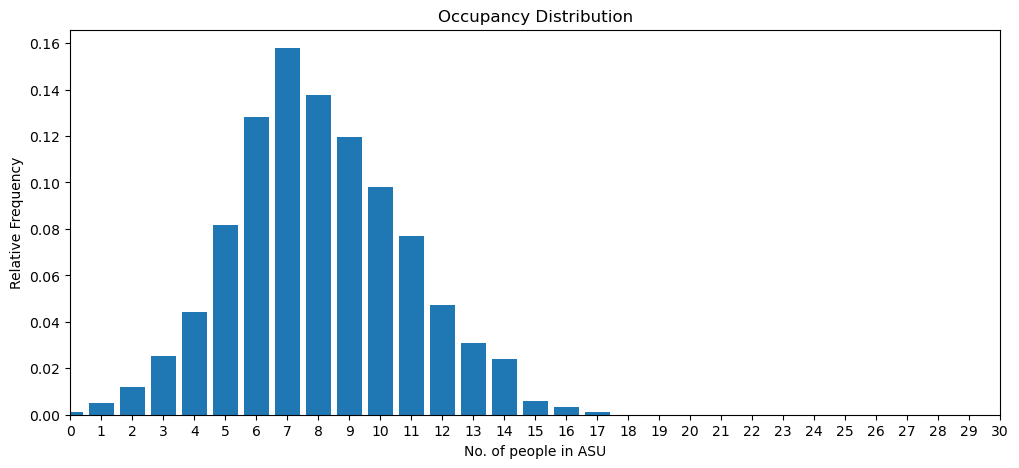

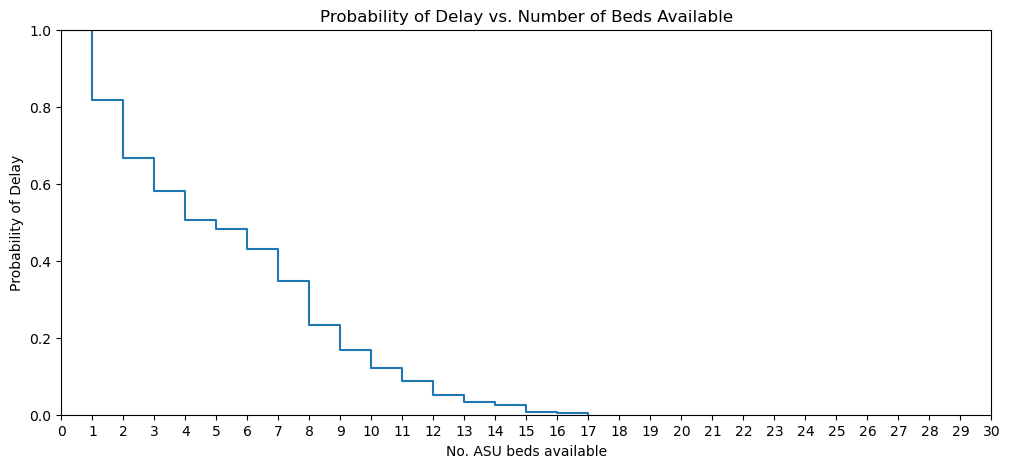


Simulation completed.
Total ASU arrivals: 2724
Final ASU occupancy: 10
Number of occupancy audits: 1824
Average occupancy: 8.03
Maximum occupancy: 17
Minimum occupancy: 0
Simulation time at end of run: 1825
Total Stroke arrivals: 1483
Total TIA arrivals: 185
Total Complex Neurological arrivals: 491
Total Other arrivals: 565


In [18]:
def run_acute_stroke_unit_model():
    # Create the experiment
    experiment = Experiment({
        'results_collection_period': 365*5,  # Run for 5 years
        'trace': False,  # Set to True if you want to see detailed logs
        'acute_audit_interval': 1  # Audit every 1 day
    })

    # Create the simulation environment
    env = simpy.Environment()

    # Create the RehabilitationUnit
    rehab_unit = RehabilitationUnit(env, experiment)

    # Create the AcuteStrokeUnit with the rehab_unit
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)

    # Start the audit process for ASU
    env.process(experiment.audit_acute_occupancy(env, experiment.warm_up, experiment.params['acute_audit_interval'], asu, experiment))

    # Run the model
    asu.run()
    env.run(until=experiment.params['results_collection_period'] + experiment.warm_up)

    # Calculate occupancy frequencies of the ASU occupancy
    rel_freq, cum_freq, unique_vals = calculate_occupancy_frequencies(experiment.asu_occupancy)

    # Display an occupancy plot for the ASU
    fig, ax = occupancy_plot(rel_freq, unique_vals, x_label="No. of people in ASU")
    plt.show()

    # Calculate the probability of delay for ASU
    prob_delay = calculate_prob_delay(rel_freq, cum_freq)

    # Display a probability of delay plot for ASU
    fig, ax = prob_delay_plot(prob_delay, unique_vals, x_label="No. ASU beds available")
    plt.show()

    print("\nSimulation completed.")
    print(f"Total ASU arrivals: {asu.total_arrivals}")
    print(f"Final ASU occupancy: {asu.occupancy}")
    print(f"Number of occupancy audits: {len(experiment.asu_occupancy)}")
    print(f"Average occupancy: {sum(experiment.asu_occupancy) / len(experiment.asu_occupancy):.2f}")
    print(f"Maximum occupancy: {max(experiment.asu_occupancy)}")
    print(f"Minimum occupancy: {min(experiment.asu_occupancy)}")
    print(f"Simulation time at end of run: {env.now}")

    for patient_type in asu.patient_types.values():
        print(f"Total {patient_type.name} arrivals: {patient_type.count}")

if __name__ == "__main__":
    run_acute_stroke_unit_model()


### Script to run the model (Rehab unit only) <a class="anchor" id="iteration_code_b"></a>

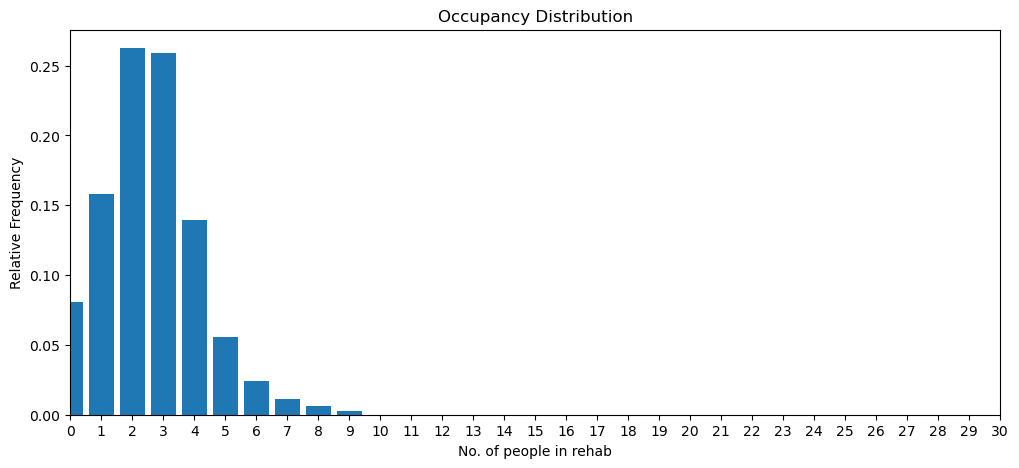

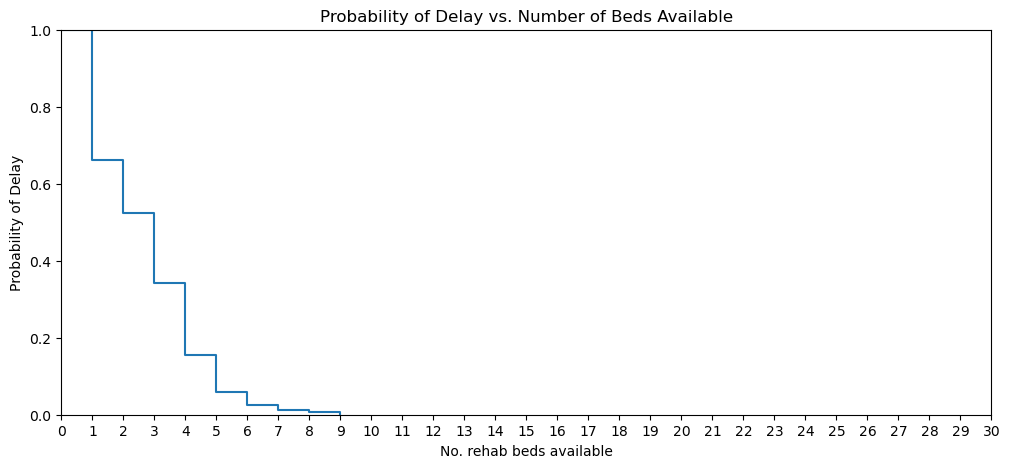


Simulation completed.
Total rehab arrivals: 191
Final rehab patient counts: {'Stroke': 80, 'Complex Neurological': 53, 'Other': 58, 'TIA': 0}


In [19]:
def run_rehabilitation_unit_model():
    experiment = Experiment({
        'run_length': 365*5,
        'trace': False,  # Set to True if you want to see detailed logs
    })
    env = simpy.Environment()
    rehab_unit = RehabilitationUnit(env, experiment)

    # Initialize the audit of rehab occupancy as a SimPy process
    env.process(experiment.audit_rehab_occupancy(env, 1, rehab_unit))  # Interval of 1 day

    # Run the model for the default run length in the experiment * 10
    env.run(until=experiment.params['run_length'])

    # Calculate occupancy frequencies of the rehab occupancy
    rel_freq, cum_freq, unique_vals = calculate_occupancy_frequencies(experiment.rehab_occupancy)

    # Display an occupancy plot for the rehab unit
    fig, ax = occupancy_plot(rel_freq, unique_vals, x_label="No. of people in rehab")
    plt.show()

    # Calculate the probability of delay for rehab
    prob_delay = calculate_prob_delay(rel_freq, cum_freq)

    # Display a probability of delay plot for rehab
    fig, ax = prob_delay_plot(prob_delay, unique_vals, x_label="No. rehab beds available")
    plt.show()

    print("\nSimulation completed.")
    print(f"Total rehab arrivals: {rehab_unit.total_arrivals}")
    print(f"Final rehab patient counts: {rehab_unit.patient_counts}")

if __name__ == "__main__":
    run_rehabilitation_unit_model()


## LLM Output Prompt 2:

This created confusion for the LLM and took several additional prompts. The main reason for this is that the two models were created separately, and the LLM chose to structure them both differently.

The approach taken here has been to let the LLM make its own choices in terms of model structure, but some changes were needed to run both models.

In addition to prompt 2, several other prompts were provided to:
> create a 'run' method in the rehab model

> Remove env.run() from inside the AcuteStrokeUnit 'run' method

> Combine the two scripts to run the models

> Manual change by tester - the main rehab_treatment function replaces individual treatment function calls to ensure occupancy is decremented.

> The additional message for post-ASU destination and the additional measure arrivals_from_asu were added by tester as part of the debugging process.
  For example:

```
if post_asu_destination == "Rehab":
    self.rehab_unit.arrivals_from_asu +=1    ## added by tester
    self.env.process(self.rehab_unit.rehab_treatment(patient_type, patient_id))  ## added by tester
    # self.env.process(self.rehab_unit.tia_rehab_treatment(patient_id)) ## removed by tester
    if self.trace:
        print(f" Post-ASU destination (tia to tia rehab): {post_asu_destination, patient_id}")  ## added by tester
```
> Extra summary measures were added to the `run_combined_model` function as part of the debugging process

In [20]:
## LLM Output: RehabilitationUnit

In [21]:
def run_rehabilitation_unit_model():
    experiment = Experiment({
        'results_collection_period': 365*5,
        'trace': False,  # Set to True if you want to see detailed logs
    })
    env = simpy.Environment()
    rehab_unit = RehabilitationUnit(env, experiment)

    # Initialize the audit of rehab occupancy as a SimPy process
    env.process(experiment.audit_rehab_occupancy(env, experiment.warm_up, experiment.params['rehab_audit_interval'], rehab_unit, experiment))

    # Run the model for the results_collection_period + warm_up
    rehab_unit.run()
    env.run(until=experiment.params['results_collection_period'] + experiment.warm_up)

    # Calculate occupancy frequencies of the rehab occupancy
    rel_freq, cum_freq, unique_vals = calculate_occupancy_frequencies(experiment.rehab_occupancy)

    # Display an occupancy plot for the rehab unit
    fig, ax = occupancy_plot(rel_freq, unique_vals, x_label="No. of people in rehab")
    plt.show()

    # Calculate the probability of delay for rehab
    prob_delay = calculate_prob_delay(rel_freq, cum_freq)

    # Display a probability of delay plot for rehab
    fig, ax = prob_delay_plot(prob_delay, unique_vals, x_label="No. rehab beds available")
    plt.show()

    print("\nSimulation completed.")
    print(f"Total rehab arrivals: {rehab_unit.total_arrivals}")
    print(f"Final rehab patient counts: {rehab_unit.patient_counts}")

if __name__ == "__main__":
    run_rehabilitation_unit_model()


## LLM output: AcuteStrokeUnit class

In [22]:
class AcuteStrokeUnit:
    def __init__(self, env, experiment, rehab_unit):
        self.env = env
        self.experiment = experiment
        self.rehab_unit = rehab_unit
        self.run_length = experiment.params['run_length']
        self.total_arrivals = 0
        self.occupancy = 0
        self.trace = experiment.params['trace']
        self.patient_types = {
            name: PatientType(name, params['interarrival_time'], params['post_asu_probabilities'], params['los_params'])
            for name, params in experiment.params['patient_types'].items()
        }

    def run(self):
        for patient_type in self.patient_types.values():
            self.env.process(self.patient_generator(patient_type))

    def patient_generator(self, patient_type):
        while True:
            interarrival_time = patient_type.generate_interarrival_time()
            yield self.env.timeout(interarrival_time)
            self.total_arrivals += 1
            patient_type.count += 1
            patient_id = self.total_arrivals - 1
            post_asu_destination = patient_type.sample_post_asu_destination()
            if self.trace:
                print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type.name}) arrived")
                print(f" Total arrivals: {self.total_arrivals}")
                print(f" {patient_type.name} arrivals: {patient_type.count}")
                print(f" Post-ASU destination: {post_asu_destination}")
                print(f" Next {patient_type.name} arrival in {interarrival_time:.2f} days")
            self.occupancy += 1
            if self.trace:
                print(f" Current occupancy: {self.occupancy}")
            self.env.process(self.acute_treatment(patient_type, patient_id, post_asu_destination))

    def acute_treatment(self, patient_type, patient_id, post_asu_destination):
        if patient_type.name == 'Stroke':
            yield from self.stroke_acute_treatment(patient_type, patient_id, post_asu_destination)
        elif patient_type.name == 'TIA':
            yield from self.tia_acute_treatment(patient_type, patient_id, post_asu_destination)
        elif patient_type.name == 'Complex Neurological':
            yield from self.complex_neurological_acute_treatment(patient_type, patient_id, post_asu_destination)
        else:  # Other
            yield from self.other_acute_treatment(patient_type, patient_id, post_asu_destination)
        self.occupancy -= 1
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type.name}) left ASU")
            print(f" Current occupancy: {self.occupancy}")

    def stroke_acute_treatment(self, patient_type, patient_id, post_asu_destination):
        los = self.patient_types['Stroke'].sample_length_of_stay(post_asu_destination)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Stroke) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Stroke) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type, patient_id))
            if self.trace:
                print(f" Post-ASU destination (stroke to stroke rehab): {post_asu_destination, patient_id}")

    def tia_acute_treatment(self, patient_type, patient_id, post_asu_destination):
        los = patient_type.sample_length_of_stay()
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (TIA) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (TIA) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type, patient_id))
            if self.trace:
                print(f" Post-ASU destination (tia to tia rehab): {post_asu_destination, patient_id}")

    def complex_neurological_acute_treatment(self, patient_type, patient_id, post_asu_destination):
        los = patient_type.sample_length_of_stay()
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Complex Neurological) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Complex Neurological) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type, patient_id))
            if self.trace:
                print(f" Post-ASU destination (complex to complex rehab): {post_asu_destination, patient_id}")

    def other_acute_treatment(self, patient_type, patient_id, post_asu_destination):
        los = patient_type.sample_length_of_stay()
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Other) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Other) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type, patient_id))
            if self.trace:
                print(f" Post-ASU destination (other to other rehab): {post_asu_destination, patient_id}")

## LLM output: combine the scripts to run the models together

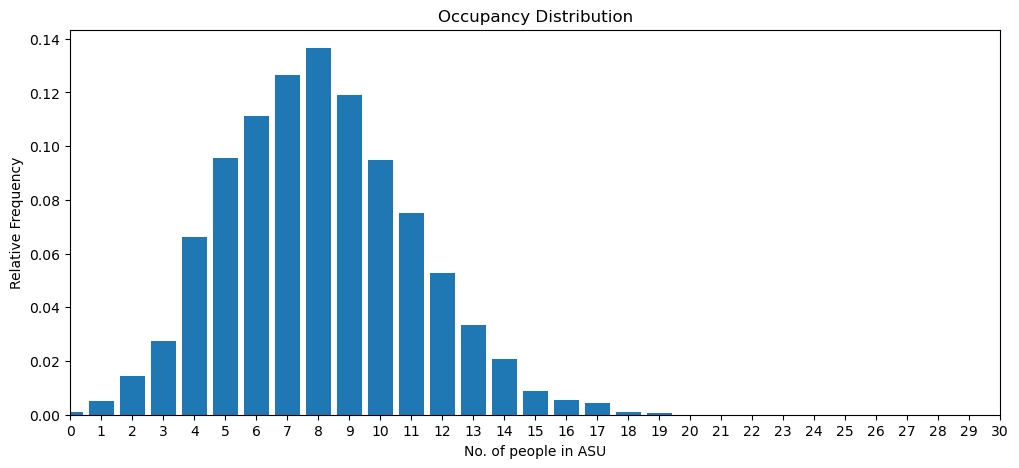

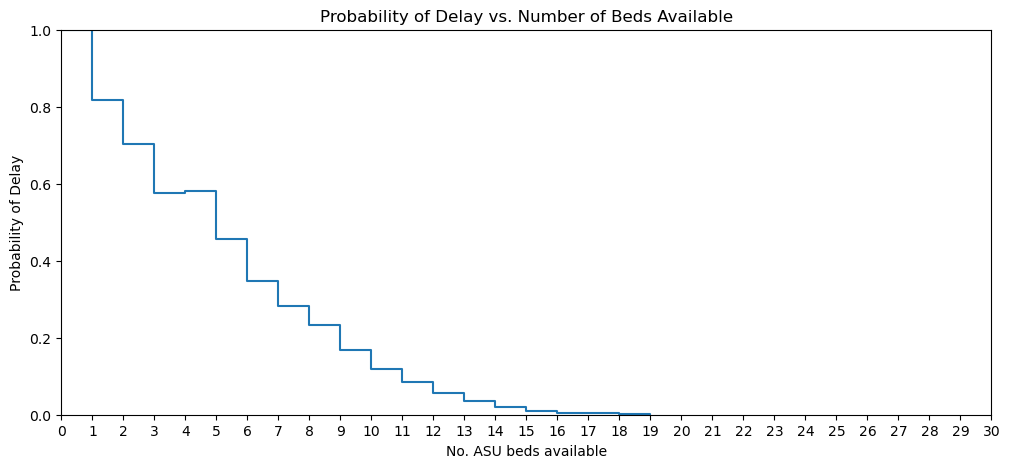

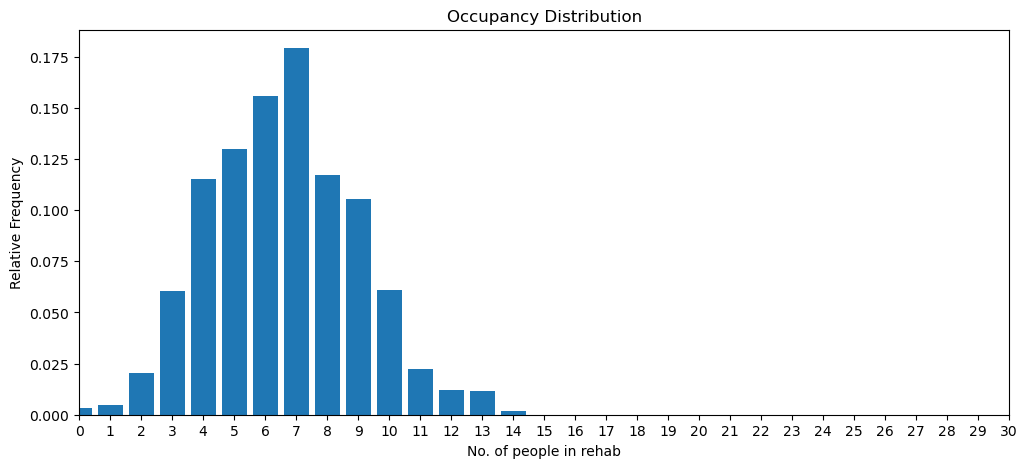

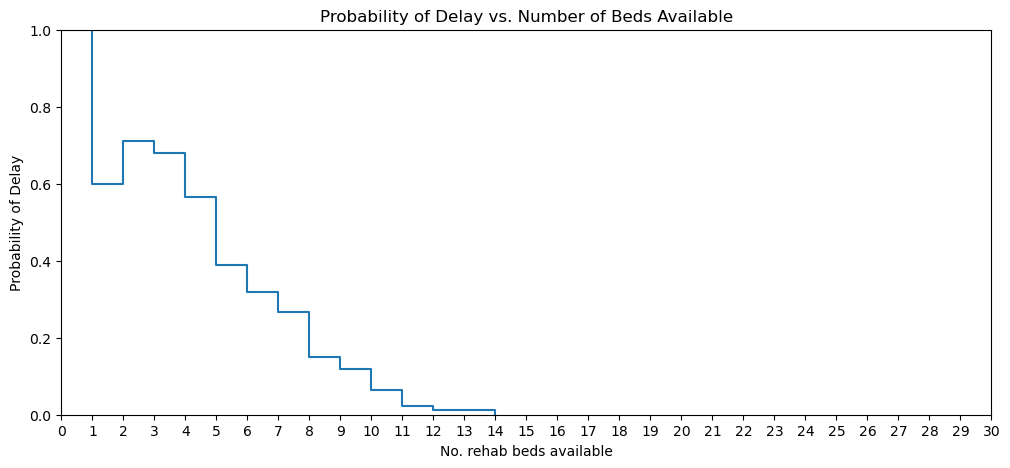


Simulation completed.
Total ASU arrivals: 2818
Total asu Stroke asu arrivals: 1555
Total asu TIA asu arrivals: 214
Total asu Complex Neurological asu arrivals: 494
Total asu Other asu arrivals: 555
Final ASU occupancy: 13
Number of occupancy audits: 1824
Average occupancy: 8.03
Maximum occupancy: 19
Minimum occupancy: 0
Simulation time at end of run: 1825

Total rehab arrivals: 213
Rehab arrivals from ASU: 457
Final rehab patient counts: {'Stroke': 94, 'Complex Neurological': 62, 'Other': 57, 'TIA': 0}
Final rehab occupancy: 6
Number of rehab occupancy audits: 1824
Average rehab occupancy: 6.58
Maximum rehab occupancy: 14
Minimum rehab occupancy: 0


In [26]:
def run_combined_acute_model():
    # Create the experiment
    experiment = Experiment({
        'results_collection_period': 365*5,  # Run for 5 years
        'trace': False,  # Set to True if you want to see detailed logs
    })

    # Create the simulation environment
    env = simpy.Environment()

    # Create the RehabilitationUnit
    rehab_unit = RehabilitationUnit(env, experiment)

    # Create the AcuteStrokeUnit with the rehab_unit
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)

    # Run models
    rehab_unit.run()
    asu.run()

    # Start the audit process 
    env.process(experiment.audit_acute_occupancy(env, experiment.warm_up, experiment.params['acute_audit_interval'], asu, experiment))
    env.process(experiment.audit_rehab_occupancy(env, experiment.warm_up, experiment.params['rehab_audit_interval'], rehab_unit, experiment))  

    # Run the model
    env.run(until=experiment.params['results_collection_period'] + experiment.warm_up)

    # Calculate occupancy frequencies 
    rel_freq_a, cum_freq_a, unique_vals_a = calculate_occupancy_frequencies(experiment.asu_occupancy)
    rel_freq_r, cum_freq_r, unique_vals_r = calculate_occupancy_frequencies(experiment.rehab_occupancy)

    # Display an occupancy plot for the ASU
    fig, ax = occupancy_plot(rel_freq_a, unique_vals_a, x_label="No. of people in ASU")
    plt.show()

    # Calculate the probability of delay for ASU
    prob_delay_a = calculate_prob_delay(rel_freq_a, cum_freq_a)

    # Display a probability of delay plot for ASU
    fig, ax = prob_delay_plot(prob_delay_a, unique_vals_a, x_label="No. ASU beds available")
    plt.show()

    # Display an occupancy plot for the rehab unit
    fig, ax = occupancy_plot(rel_freq_r, unique_vals_r, x_label="No. of people in rehab")
    plt.show()

    # Calculate the probability of delay for rehab
    prob_delay_r = calculate_prob_delay(rel_freq_r, cum_freq_r)

    # Display a probability of delay plot for rehab
    fig, ax = prob_delay_plot(prob_delay_r, unique_vals_r, x_label="No. rehab beds available")
    plt.show()

    print("\nSimulation completed.")
    print(f"Total ASU arrivals: {asu.total_arrivals}")
    for patient_type in asu.patient_types.values():
        print(f"Total asu {patient_type.name} asu arrivals: {patient_type.count}")
    print(f"Final ASU occupancy: {asu.occupancy}")
    print(f"Number of occupancy audits: {len(experiment.asu_occupancy)}")
    print(f"Average occupancy: {sum(experiment.asu_occupancy) / len(experiment.asu_occupancy):.2f}")
    print(f"Maximum occupancy: {max(experiment.asu_occupancy)}")
    print(f"Minimum occupancy: {min(experiment.asu_occupancy)}")
    print(f"Simulation time at end of run: {env.now}")
    print()
    print(f"Total rehab arrivals: {rehab_unit.total_arrivals}")
    print(f"Rehab arrivals from ASU: {rehab_unit.arrivals_from_asu}")
    print(f"Final rehab patient counts: {rehab_unit.patient_counts}")
    print(f"Final rehab occupancy: {rehab_unit.occupancy}")
    print(f"Number of rehab occupancy audits: {len(experiment.rehab_occupancy)}")
    print(f"Average rehab occupancy: {sum(experiment.rehab_occupancy) / len(experiment.rehab_occupancy):.2f}")
    print(f"Maximum rehab occupancy: {max(experiment.rehab_occupancy)}")
    print(f"Minimum rehab occupancy: {min(experiment.rehab_occupancy)}")

if __name__ == "__main__":
    run_combined_acute_model()


## Testing <a class="anchor" id="testing_code"></a>
* **Results processing 1**: code correctly calculates relative and cumulative frequencies
    * Expected result: for [1, 1, 1, 1, 2, 2, 2, 3, 3, 4] relative = [4/10, 3/10, 2/10, 1/10] and cum = [4/10, 7/10, 9/10, 1.0]
    * Actual result (PASS): for [1, 1, 1, 1, 2, 2, 2, 3, 3, 4] relative = [4/10, 3/10, 2/10, 1/10] and cum = [4/10, 7/10, 9/10, 1.0]
* **Results processing 2**: test that prob delay is calculated correctly.
    * Expected result: The probability of delay is [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
    * Actual result (PASS): The probability of delay is [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
* **Results collection test 1**: Test the result collection process for ASU collects ward occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Results collection test 2**: Test ASU ward occupancy data collected is in a sensible range.
    * Expected result: The type collected is int. The values are in the range 0 to 50 with sensible moments.
    * Actual result (PASS):  The type collected is int. The values are in the range 0 to 50 with sensible moments.
* **Results collection test 3**: Test the result collection process for REHAB collects unit occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Results collection test 4**: Test REHAB unit occupancy data collected is in a sensible range.
    * Expected result: The type collected is int. The values are in the range 0 to (10-15) with sensible moments.
    * Actual result (PASS):  The type collected is int. The values are 0 to (10-15) with sensible moments.
* **Results collection test 5**: **SYSTEM TEST**: Test the result collection process for ASU+REHAB collects ward occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Suppress simulated trace**: Test that setting experiment.trace = False suppresses ASU output by default.
    * Expected result: The ASU model runs with no simulated log output
    * Actual result (PASS): The ASU model runs with no simulated log output
* **Suppress simulated trace 2**: Test that setting experiment.trace = False suppresses REHAB output by default.
    * Expected result: The REHAB model runs with no simulated log output
    * Actual result (PASS): The REHAB model runs with no simulated log output
* **Testing lognormal function**: Test that lognomal function correctly calculates the moments of the underlying normal dist.
    * Expected result: The LLM generated function and `sim-tools.distributions.Lognormal` perform the same conversion.
    * Actual results (PASS):  The functions generate the same values.
* **Extreme value test 1**: TIA, Complex Neuro, Other, have their inter-arrival time is set to $M$ a very large number
    * Expected result: The only type of patient to arrive to the model is "Stroke"
    * Actual result (PASS): The only type of patient to arrive to the model is "Stroke"
* **Extreme value test 2**: All patient types have have their inter-arrival time is set to $M$ a very large number
    * Expected result: No patients arrive to the model.
    * Actual result (PASS): No patients arrive to the model.
* **Different run length**: The run length of the model is set to 10 days.
    * Expected result: The model should runs no longer than 10 simulated time periods
    * Actual result (PASS): The model runs no longer than 10 simulated time periods
* **Extreme value test 3**: All patient types have have their mean length of stay time set to $M$ a very large number
    * Expected result: No patients depart the model (only arrivals seen in log)
    * Actual Results (PASS): No patients depart the model.
* **Extreme value test 4**: All patient types apart from stroke->rehab have have their mean length of stay time set to $M$ a very large number
    * Expected result: Only stroke patients depart the model (seen in log)
    * Actual Results (PASS): Only stroke patient depart the model.
* **Extreme value test 5**: In rehab, Complex Neuro, and Other, have their inter-arrival time is set to $M$ a very large number
    * Expected result: The only type of patient to arrive to the rehab model is "Stroke"
    * Actual result (PASS): The only type of patient to arrive to the rehab model is "Stroke"
* **Extreme value test 6**: In the rehab model, all patient types have have their inter-arrival time is set to $M$ a very large number
    * Expected result: No patients arrive to the model.
    * Actual result (PASS): No patients arrive to the model.
* **Extreme value test 7**: In the rehab model, all patient types have their length of stay means set to $M$ a very larger number.
    * Expected result: Patients arrive to the model as normal, but do not depart.
    * Actual result (PASS): Patients arrive to the model as normal, but do not depart.

### Results processing 1

Test that the code correctly calculates the relative and cumulative frequencies of a python list of integer values.

(PASS)

In [81]:
def result_processing_test_1(values, rel_expected, cum_expected):
    '''
    Test the `calculate_occupancy_frequencies` function works
    as expected.

    Expected result: relative frequencies and cumulative freqs
    are the same as expected values.

    Params:
    ------
    values: list
        list of values to test

    rel_expected: list
        list of floats - expected relative freqs

    cum_expected: list
        list of floats - expected cumulative freqs

    Returns:
    -------
    bool: does the model pass the test.
    '''
    rel, cum, unique = calculate_occupancy_frequencies(values)
    # use all close to allow for minor floating point differences.
    return (set(rel) == set(rel_expected)) and  np.allclose(np.array(cum_expected), cum)

In [82]:
result_processing_test_1(values=[1, 1, 1, 1, 2, 2, 2, 3, 3, 4],
                         rel_expected=[0.4, 0.3, 0.2, 0.1],
                         cum_expected=[0.4, 0.7, 0.9, 1.0])

True

### Results Processing test 2

Test that the calculation of the probability of delay is correct.

(PASS)

In [83]:
def result_processing_test_2(relative, cum, p_delay_expected):
    '''
    Test the probability of delay is calculated correctly.
    
    Params:
    ------
    relative: list
        list of floats - relative freqs

    cum: list
        list of floats - cumulative freqs

    Returns:
    -------
    bool: does the function pass the test.
    '''
    p_delay = calculate_prob_delay(relative, cum)
    # use all close to allow for minor floating point differences.
    return np.allclose(np.array(p_delay_expected), p_delay)

In [84]:
relative = [0.4, 0.3, 0.2, 0.1],
cum = [0.4, 0.7, 0.9, 1.0]
expected = [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
result = result_processing_test_2(relative, cum, expected)
result

True

### Results collection test 1

Test the optional results collection process works correctly.  The process should collect acute stroke occupancy every day

(PASS)

In [92]:
def results_collection_test1(audit_interval=1):
    '''
    Test the model collects acute stroke occupancy every day

    Expected result: len(experiment.asu_occupancy) == env.now

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the experiment
    experiment = Experiment({
        'run_length': 365*5,  # Run for 5 years
        'trace': False,  # Set to True if you want to see detailed logs
        'acute_audit_interval': audit_interval  # Audit interval as specified
    })

    # Create the simulation environment
    env = simpy.Environment()

    rehab_unit = RehabilitationUnit(env, experiment)

    # Create the AcuteStrokeUnit
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)

    # Start the audit process
    env.process(experiment.audit_acute_occupancy(env, experiment.params['acute_audit_interval'], asu))

    # Run the model
    asu.run()
    env.run(until=experiment.params['run_length'])

    print(f"Number of occupancy audits: {len(experiment.asu_occupancy)}")
    print(f'Simulation time: {env.now}')
    
    # The number of audits should be equal to the simulation time
    # (assuming audit_interval=1 and the first audit happens at time 1)
    return len(experiment.asu_occupancy) == (env.now - 1)


In [93]:
results_collection_test1(1)

Number of occupancy audits: 1824
Simulation time: 1825


True

### Result collection test 2

(PASS)

In [94]:
def results_collection_test2(audit_interval=1):
    '''
    Test ASU ward occupancy data collected is in a sensible range.
    
    Expected result: The type collected is int. The values are in 
    the range in the range 0 to 50 with sensible moments.

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    None
    '''

    # Create the experiment
    experiment = Experiment({
        'trace': False,
        'acute_audit_interval': audit_interval
    })

    # Create the simulation environment
    env = simpy.Environment()

    rehab_unit = RehabilitationUnit(env, experiment)


    # Create the AcuteStrokeUnit
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)

    # Start the audit process
    env.process(experiment.audit_acute_occupancy(env, experiment.params['acute_audit_interval'], asu))

    # Run the model
    asu.run()
    env.run(until=experiment.params['run_length'])

    # Calculate statistics
    min_occupancy = min(experiment.asu_occupancy)
    max_occupancy = max(experiment.asu_occupancy)
    mean_occupancy = statistics.fmean(experiment.asu_occupancy)
    deciles = [round(q, 1) for q in statistics.quantiles(experiment.asu_occupancy, n=10)]

    # Print results
    print(f'Minimum occupancy: {min_occupancy}')
    print(f'Maximum occupancy: {max_occupancy}')
    print(f'Mean occupancy: {mean_occupancy:.2f}')
    print(f'Deciles of occupancy: {deciles}')


In [95]:
results_collection_test2()

Minimum occupancy: 0
Maximum occupancy: 19
Mean occupancy: 8.38
Deciles of occupancy: [5.0, 6.0, 7.0, 8.0, 8.0, 9.0, 10.0, 11.0, 12.0]


### Results collection test 3

Test the optional results collection process works correctly for rehab.  The process should collect rehab unit occupancy every day.

(PASS)


In [96]:
def results_collection_test3(audit_interval=1):
    '''
    Test the model collects rehab occupancy every day

    Expected result: len(experiment.rehab_occupancy) == env.now - 1

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()

    # create experiment
    default_experiment = Experiment()
    
    rehab_unit = RehabilitationUnit(env, default_experiment)

    # Initialise the audit of rehab occupancy as a simpy process with an interval of 1 day
    env.process(default_experiment.audit_rehab_occupancy(env, audit_interval, rehab_unit))
    
    # Run the model for the default run length in the experiment
    env.run(until=default_experiment.params['run_length'])
    
    print(f'{len(default_experiment.rehab_occupancy)=}')
    print(f'{env.now=}')
    return len(default_experiment.rehab_occupancy) == (env.now - 1)

In [97]:
results_collection_test3()

len(default_experiment.rehab_occupancy)=1824
env.now=1825


True

## Results Collection Test 4

(PASS)

In [101]:
def results_collection_test4(audit_interval=1):
    '''
    Test REHAB ward occupancy data collected is in a sensible range.
    
    Expected result: The type collected is int. The values are in 
    the range 1 to [10-15] with sensible moments.

    Note this is when the Rehab unit is used independently
    with external arrivals only i.e. no transfers from ASU.

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    None
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # create experiment
    default_experiment = Experiment()
    
    rehab_unit = RehabilitationUnit(env, default_experiment)
    
    # Initialise the audit of rehab occupancy as a simpy process with an interval of 1 day
    env.process(default_experiment.audit_rehab_occupancy(env, audit_interval, rehab_unit))
    
    # Run the model for the default run length in the experiment
    rehab_unit.run()
    env.run(until=default_experiment.params['run_length'])
    
    print(f'min(default_experiment.rehab_occupancy)={min(default_experiment.rehab_occupancy)}')
    print(f'max(default_experiment.rehab_occupancy)={max(default_experiment.rehab_occupancy)}')
    print(f'statistics.fmean(default_experiment.rehab_occupancy)={statistics.fmean(default_experiment.rehab_occupancy):.2f}')
    print('Deciles:', [round(q, 1) for q in statistics.quantiles(default_experiment.rehab_occupancy, n=10)])


In [102]:
results_collection_test4()

min(default_experiment.rehab_occupancy)=0
max(default_experiment.rehab_occupancy)=7
statistics.fmean(default_experiment.rehab_occupancy)=2.39
Deciles: [1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0]


### Results Collection Test 5 (SYSTEM TEST)

Test that when the models are linked that the occupancy is audited correctly.

In [114]:
def results_collection_test5(audit_interval=1):
    '''
    Test REHAB ward occupancy data collected is in a sensible range
    when it is connected to the ASU model.
    
    Expected result: The type collected is int. The values are in 
    the range in the range 1 to [10-15] with sensible moments.

    Expected result: 
        len(experiment.asu_occupancy) == env.now - 1 AND
        len(experiment.rehab_occupancy) == env.now - 1

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Create an experiment with default parameters
    experiment = Experiment()

    # Create models
    rehab_unit = RehabilitationUnit(env, experiment)
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    asu.run()
    rehab_unit.run()

    # Start the audit processes for both ASU and Rehab
    env.process(experiment.audit_acute_occupancy(env, audit_interval, asu))
    env.process(experiment.audit_rehab_occupancy(env, audit_interval, rehab_unit))
    
    # Run the simulation until the specified run length in the Experiment parameters
    env.run(until=experiment.params['run_length'])

    # Print info for debug
    print(f"Average rehab occupancy: {sum(experiment.rehab_occupancy) / len(experiment.rehab_occupancy):.2f}")
    print(f"Maximum rehab occupancy: {max(experiment.rehab_occupancy)}")
    print(f"Minimum rehab occupancy: {min(experiment.rehab_occupancy)}")
    print(f'{len(experiment.asu_occupancy)=}')
    print(f'{len(experiment.rehab_occupancy)=}')
    print(f'{env.now=}')

    # Test
    return len(experiment.asu_occupancy) == (env.now - 1) and \
           len(experiment.rehab_occupancy) == (env.now - 1)


In [115]:
results_collection_test5()

Average rehab occupancy: 6.67
Maximum rehab occupancy: 13
Minimum rehab occupancy: 1
len(experiment.asu_occupancy)=1824
len(experiment.rehab_occupancy)=1824
env.now=1825


True

In [105]:
### Results Collection Test 6 (SYSTEM TEST)


In [118]:
def results_collection_test6(audit_interval=1):
    '''
    Test the model collects acute stroke occupancy every day

    Expected result: The type collected is int. The values are in 
    the range in the range 1 to ~25 with sensible moments.

    Note this is when the Rehab unit is linked to the ASU.
    I.e. transfers from ASU + external arrivals

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Create an experiment with default parameters
    experiment = Experiment()

    # Create models
    rehab_unit = RehabilitationUnit(env, experiment)
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    asu.run()
    rehab_unit.run()

    # Start the audit processes for both ASU and Rehab
    env.process(experiment.audit_acute_occupancy(env, audit_interval, asu))
    env.process(experiment.audit_rehab_occupancy(env, audit_interval, rehab_unit))
    
    # Run the simulation until the specified run length in the Experiment parameters
    env.run(until=experiment.params['run_length'])

    # Print info for debug
    print(f"Average occupancy: {sum(experiment.asu_occupancy) / len(experiment.asu_occupancy):.2f}")
    print(f"Maximum occupancy: {max(experiment.asu_occupancy)}")
    print(f"Minimum occupancy: {min(experiment.asu_occupancy)}")
    print(f'{len(experiment.asu_occupancy)=}')
    print(f'{len(experiment.rehab_occupancy)=}')
    print(f'{env.now=}')

    # Test
    return len(experiment.asu_occupancy) == (env.now - 1) and \
           len(experiment.rehab_occupancy) == (env.now - 1)


In [119]:
results_collection_test6()

Average occupancy: 8.45
Maximum occupancy: 20
Minimum occupancy: 0
len(experiment.asu_occupancy)=1824
len(experiment.rehab_occupancy)=1824
env.now=1825


True

## Test suppress trace 1

(PASS)

In [132]:
def test_suppress_log(trace):
    '''
    Test that setting experiment.trace 
    False suppresses output.

    Expected result: patient_count > 0

    Params:
    ------
    trace: bool
        is trace outputted or not?

    Returns:
    -------
    int: number of patient arrivals.
    '''

    experiment = Experiment({'trace': trace})
    env = simpy.Environment()
    rehab_unit = RehabilitationUnit(env, experiment)
    model = AcuteStrokeUnit(env, experiment, rehab_unit)
    model.run()
    env.run(until=experiment.params['run_length'])
    
    print("\nSimulation completed.")
    print(f"Total simulation time: {model.env.now:.2f} days")
    print(f"Total patient arrivals: {model.total_arrivals}")
    for patient_type in model.patient_types.values():
        print(f"Total {patient_type.name} arrivals: {patient_type.count}")



In [133]:
test_suppress_log(trace=False)


Simulation completed.
Total simulation time: 1825.00 days
Total patient arrivals: 2720
Total Stroke arrivals: 1491
Total TIA arrivals: 186
Total Complex Neurological arrivals: 487
Total Other arrivals: 556


### Test suppress trace 2

In [130]:
def test_suppress_log_rehab(trace):
    '''
    Test that setting experiment.trace to
    False suppresses output in the rehab model

    Expected result: patient_count > 0

    Params:
    ------
    trace: bool
        is trace outputted or not?

    Returns:
    -------
    int: number of patient arrivals.
    '''
    # Create the simulation environment


    experiment = Experiment({'trace': trace})
    env = simpy.Environment()
    model = RehabilitationUnit(env, experiment)
    asu = AcuteStrokeUnit(env, experiment, model)
    model.run()
    env.run(until=experiment.params['run_length'])
    
    print("\nSimulation completed.")
    print(f"Total simulation time: {model.env.now:.2f} days")
    print(f"Total patient arrivals: {model.total_arrivals}")
    print(f"Final rehab patient counts: {model.patient_counts}")


In [131]:
test_suppress_log_rehab(False)


Simulation completed.
Total simulation time: 1825.00 days
Total patient arrivals: 221
Final rehab patient counts: {'Stroke': 75, 'Complex Neurological': 66, 'Other': 80, 'TIA': 0}


### Lognormal test

Test that lognomal function correctly calculates the moments of the underlying normal dist.

**Result: PASS**

In [144]:
def test_lognormal_moments(mean, std):
    '''
    Test that lognomal function correctly calculates 
    the moments of the underlying normal dist.

    Params:
    ------
    mean: float
        mean of the lognormal distribution

    std: float
        st dev of the lognormal distribution

    Returns:
    -------
    bool
    '''
   
    # Lognormal class from sim-tools.
    expected_moments = Lognormal(mean, std)
    print(expected_moments.mu, expected_moments.sigma)

    # Convert lognormal parameters from llm for asu
    normal_mean = math.log(mean**2 / math.sqrt(std**2 + mean**2))
    normal_std = math.sqrt(math.log(1 + (std**2 / mean**2)))
    print(normal_mean, normal_std)

    # Check lognormal calculations from llm used in rehab model
    rehab_mean = np.log(mean**2 / np.sqrt(std**2 + mean**2)) 
    rehab_std = np.sqrt(np.log(1 + (std**2 / mean**2)))
    print (rehab_mean, rehab_std)


    return (normal_mean, normal_std) == (expected_moments.mu, expected_moments.sigma) == (rehab_mean, rehab_std)

In [145]:
test_lognormal_moments(128.79, 267.51)

4.022977459259615 1.2924439729790718
4.022977459259615 1.2924439729790718
4.022977459259615 1.2924439729790718


True

### Extreme value test 1

The model uses hard coded parameters.  The most simple way to modify the code for this test was to change hard coded parameters for $M$

**Result: PASS**

In [148]:
M = 10_000_000

In [149]:
def ev_test_1(large_number):
    '''
    TIA, Complex Neuro, Other, have their inter-arrival 
    time set to $M$ a very large number
    
    Expected result: The only type of patient to arrive to the model 
    is "Stroke". This is seen in the event log

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    int: the number of patients that arrived to the model.
    '''

    def main(arrival_rates=None, run_length=None):
        custom_params = {}
        
        if arrival_rates:
            custom_params['patient_types'] = arrival_rates
        
        if run_length:
            custom_params['run_length'] = run_length
    
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)
    
        # Run the simulation with the custom experiment
        env = simpy.Environment()
        rehab_unit = RehabilitationUnit(env, experiment)
        model = AcuteStrokeUnit(env, experiment, rehab_unit)
        model.run()
        env.run(until=experiment.params['run_length'])
    
        # Print results to check
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")
    
    if __name__ == "__main__":
        large_number = M
        
        asu_arrival_rates = {
            'Stroke': {'interarrival_time': 1.2},
            'TIA': {'interarrival_time': large_number},
            'Complex Neurological': {'interarrival_time': large_number},
            'Other': {'interarrival_time': large_number}
        }
    
    main(asu_arrival_rates, run_length=2*365)  # Run for 2 years with custom parameters


In [150]:
ev_test_1(M)


Simulation completed.
Total simulation time: 730.00 days
Total patient arrivals: 583
Total Stroke arrivals: 583
Total TIA arrivals: 0
Total Complex Neurological arrivals: 0
Total Other arrivals: 0


### Extreme value test 2

* An experiment is setup so that all patient types have a mean inter-arrival rate of $M$

**Result: PASS**

In [151]:
def ev_test_2(large_number):
    '''
    All patient types have have their inter-arrival time is 
    set to $M$ a very large number
    
    Expected result: No patients arrive to the model.
    
    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    int: the number of patients that arrived to the model.
    '''

    def main(arrival_rates=None, run_length=None):
        custom_params = {}
        
        if arrival_rates:
            custom_params['patient_types'] = arrival_rates
        
        if run_length:
            custom_params['run_length'] = run_length
    
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)
    
        # Run the simulation with the custom experiment
        env = simpy.Environment()
        rehab_unit = RehabilitationUnit(env, experiment)
        model = AcuteStrokeUnit(env, experiment, rehab_unit)
        model.run()
        env.run(until=experiment.params['run_length'])
    
        # Print results to check
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")
    
    if __name__ == "__main__":
        large_number = M
        
        asu_arrival_rates = {
            'Stroke': {'interarrival_time': large_number},
            'TIA': {'interarrival_time': large_number},
            'Complex Neurological': {'interarrival_time': large_number},
            'Other': {'interarrival_time': large_number}
        }
    
    main(asu_arrival_rates, run_length=2*365)  # Run for 2 years with custom parameters


In [152]:
ev_test_2(M)


Simulation completed.
Total simulation time: 730.00 days
Total patient arrivals: 0
Total Stroke arrivals: 0
Total TIA arrivals: 0
Total Complex Neurological arrivals: 0
Total Other arrivals: 0


### Different run length test

The model has again been modified to use the original code and parameters generated by the LLM.

In [153]:
TEN_DAYS = 10

In [156]:
def test_run_length(run_length):
    '''
    Test that the run length of the model can be modified.
    
    Expected result: The model should runs no longer than the new run length.

    Params:
    ------
    run_length: float
        Run length of the model in days.

    Returns:
    -------
    float
        Simulation end time.
    '''
    def main(run_length=None):
        custom_params = {}
        
        if run_length:
            custom_params['run_length'] = run_length
    
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)

        # Run the simulation with the custom experiment
        env = simpy.Environment()
        rehab_unit = RehabilitationUnit(env, experiment)
        model = AcuteStrokeUnit(env, experiment, rehab_unit)
        model.run()
        env.run(until=experiment.params['run_length'])
    
        # Print results to check
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")
    if __name__ == "__main__":
        main(run_length=run_length)


In [157]:
test_run_length(TEN_DAYS)


Simulation completed.
Total simulation time: 10.00 days
Total patient arrivals: 12
Total Stroke arrivals: 6
Total TIA arrivals: 3
Total Complex Neurological arrivals: 1
Total Other arrivals: 2


### Extreme value test 3

* An experiment is setup so that all patient types have a mean length of stay on the ASU of $M$

**Result: PASS**

In [161]:
def ev_test_3(large_number):
    '''
    All patient types have have their mean length 
    of stay time set to $M$ a very large number
    
    Expected result: No patients depart the model 
    (only arrivals seen in log)

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    def main(los_params=None, run_length=None, trace=True):
        custom_params = {'patient_types': {}}
        
        if los_params:
            for patient_type, los in los_params.items():
                if patient_type not in custom_params['patient_types']:
                    custom_params['patient_types'][patient_type] = {}
                custom_params['patient_types'][patient_type]['los_params'] = los
        
        if run_length:
            custom_params['run_length'] = run_length

        
        if trace:
            custom_params['trace'] = True
            
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)
    
        # Run the simulation with the custom experiment
        env = simpy.Environment()
        rehab_unit = RehabilitationUnit(env, experiment)
        model = AcuteStrokeUnit(env, experiment, rehab_unit)
        model.run()
        env.run(until=experiment.params['run_length'])
    
        # Print results
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        print(f"Total occupancy: {model.occupancy}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")

        return model  # Return the model so we can access its attributes

    # New length of stay parameters - stdev is default
    new_los_params = {
        'Stroke': {'Rehab': (large_number, 8.6), 'ESD': (large_number, 4.8), 'Other': (large_number, 8.7)},
        'TIA': (large_number, 5.0),
        'Complex Neurological': (large_number, 5.0),
        'Other': (large_number, 5.2)
    }

    # Run the simulation with new parameters
    model = main(los_params=new_los_params, run_length=2*365)

    # Check if the total number of arrivals is greater than the final occupancy
    total_arrivals = model.total_arrivals
    final_occupancy = model.occupancy

    return total_arrivals == final_occupancy

In [162]:
result = ev_test_3(M)

Time 0.04: Patient 0 (Other) arrived
 Total arrivals: 1
 Other arrivals: 1
 Post-ASU destination: ESD
 Next Other arrival in 0.04 days
 Current occupancy: 1
Time 0.04: Patient 0 (Other) starting acute treatment
 Length of stay: 10000008.61 days
Time 0.13: Patient 1 (Stroke) arrived
 Total arrivals: 2
 Stroke arrivals: 1
 Post-ASU destination: Rehab
 Next Stroke arrival in 0.13 days
 Current occupancy: 2
Time 0.13: Patient 1 (Stroke) starting acute treatment
 Length of stay: 10000013.37 days
Time 1.35: Patient 2 (Other) arrived
 Total arrivals: 3
 Other arrivals: 2
 Post-ASU destination: Other
 Next Other arrival in 1.30 days
 Current occupancy: 3
Time 1.35: Patient 2 (Other) starting acute treatment
 Length of stay: 9999995.45 days
Time 2.29: Patient 3 (TIA) arrived
 Total arrivals: 4
 TIA arrivals: 1
 Post-ASU destination: Other
 Next TIA arrival in 2.29 days
 Current occupancy: 4
Time 2.29: Patient 3 (TIA) starting acute treatment
 Length of stay: 10000006.07 days
Time 3.17: Patient 

In [160]:
result

True

### Extreme value test 4

* An experiment is setup so that all patient types other than stroke->rehab have a mean length of stay on the ASU of $M$

**Result: PASS**

In [163]:
def ev_test_4(large_number):
    '''
    All patient types apart from stroke-rehab patients
    have have their mean length 
    of stay time set to $M$ a very large number
    
    Expected result: Only stroke patients depart the
    model.
    (only arrivals seen in log)

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    
    def main(los_params=None, run_length=None, trace=True):
        custom_params = {'patient_types': {}}
        
        if los_params:
            for patient_type, los in los_params.items():
                if patient_type not in custom_params['patient_types']:
                    custom_params['patient_types'][patient_type] = {}
                custom_params['patient_types'][patient_type]['los_params'] = los
        
        if run_length:
            custom_params['run_length'] = run_length

        if trace:
            custom_params['trace'] = True
    
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)
    
        # Run the simulation with the custom experiment
        env = simpy.Environment()
        rehab_unit = RehabilitationUnit(env, experiment)
        model = AcuteStrokeUnit(env, experiment, rehab_unit)
        model.run()
        env.run(until=experiment.params['run_length'])
    
        # Print results
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        print(f"Total occupancy: {model.occupancy}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")

        return model  # Return the model so we can access its attributes

    # New length of stay parameters - stdev is default
    new_los_params = {
        'Stroke': {'Rehab': (7.4, 8.6), 'ESD': (large_number, 4.8), 'Other': (large_number, 8.7)},
        'TIA': (large_number, 5.0),
        'Complex Neurological': (large_number, 5.0),
        'Other': (large_number, 5.2)
    }

    # Run the simulation with new parameters
    model = main(los_params=new_los_params, run_length=2*365)

    # Check if the total number of arrivals is greater than the final occupancy
    total_arrivals = model.total_arrivals
    final_occupancy = model.occupancy

    return total_arrivals > final_occupancy


In [164]:
results = ev_test_4(M)

Time 0.06: Patient 0 (Stroke) arrived
 Total arrivals: 1
 Stroke arrivals: 1
 Post-ASU destination: Rehab
 Next Stroke arrival in 0.06 days
 Current occupancy: 1
Time 0.06: Patient 0 (Stroke) starting acute treatment
 Length of stay: 7.04 days
Time 0.59: Patient 1 (Stroke) arrived
 Total arrivals: 2
 Stroke arrivals: 2
 Post-ASU destination: Other
 Next Stroke arrival in 0.53 days
 Current occupancy: 2
Time 0.59: Patient 1 (Stroke) starting acute treatment
 Length of stay: 9999999.38 days
Time 0.90: Patient 2 (TIA) arrived
 Total arrivals: 3
 TIA arrivals: 1
 Post-ASU destination: Other
 Next TIA arrival in 0.90 days
 Current occupancy: 3
Time 0.90: Patient 2 (TIA) starting acute treatment
 Length of stay: 10000001.27 days
Time 1.63: Patient 3 (Stroke) arrived
 Total arrivals: 4
 Stroke arrivals: 3
 Post-ASU destination: Other
 Next Stroke arrival in 1.03 days
 Current occupancy: 4
Time 1.63: Patient 3 (Stroke) starting acute treatment
 Length of stay: 9999992.03 days
Time 1.70: Patien

In [ ]:
results

### Extreme value test 5

Only stroke arrivals to the Rehab unit

(PASS)

In [167]:
def ev_test_5(large_number):
    '''
    Complex Neuro, Other, have their rehab inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: The only type of patient to arrive to the rehab model 
    is "Stroke". This is verified by the patient counts variables in the model.

    Notes:
    ------
    This test will need to be modified when the hardcoded parameters
    are migrated to the Experiment class. 

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    bool: rehab_unit.stroke_count == rehab_unit.patient_count
    
    '''

    # Create the simulation environment
    experiment = Experiment({
        'trace': False,  # Set to True if you want to see detailed logs
        'rehab_stroke_iat': 21.8,
        'rehab_neuro_iat': large_number,
        'rehab_other_iat': large_number
    })
    env = simpy.Environment()
    rehab_unit = RehabilitationUnit(env, experiment)
    rehab_unit.run()
    env.run(until=experiment.params['run_length'])

    # Print out stats collected
    print(f"Patient counts:")
    for patient_type, count in rehab_unit.patient_counts.items():
        print(f"  {patient_type}: {count}")

    print(f"Total arrivals: {rehab_unit.total_arrivals}")
    
    # Check if only Stroke patients arrived
    return rehab_unit.patient_counts['Stroke'] == rehab_unit.total_arrivals

    print(f"Total arrivals: {rehab_unit.total_arrivals}")


In [168]:
ev_test_5(M)

Patient counts:
  Stroke: 74
  Complex Neurological: 0
  Other: 0
  TIA: 0
Total arrivals: 74


True

### Extreme Value test 6

No arrivals to the rehab unit.

(PASS)

In [171]:
def ev_test_6(large_number):
    '''
    All patients have their rehab inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: No patients will arrive in the model

    Notes:
    ------
    This test will need to be modified when the hardcoded parameters
    are migrated to the Experiment class. 

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    bool: rehab_unit.stroke_count == rehab_unit.patient_count
    
    '''

    # Create the simulation environment
    experiment = Experiment({
        'trace': True,  # Set to True if you want to see detailed logs
        'rehab_stroke_iat': large_number,
        'rehab_neuro_iat': large_number,
        'rehab_other_iat': large_number
    })
    env = simpy.Environment()
    rehab_unit = RehabilitationUnit(env, experiment)
    rehab_unit.run()
    env.run(until=experiment.params['run_length'])

    # Print out stats collected
    print(f"Patient counts:")
    for patient_type, count in rehab_unit.patient_counts.items():
        print(f"  {patient_type}: {count}")

    print(f"Total arrivals: {rehab_unit.total_arrivals}")
    
    print(f"Total arrivals: {rehab_unit.total_arrivals}")


In [172]:
ev_test_6(M)

Patient counts:
  Stroke: 0
  Complex Neurological: 0
  Other: 0
  TIA: 0
Total arrivals: 0
Total arrivals: 0


### Extreme value test 7

In the rehab model, all patient types have their length of stay means set to $M$ a very larger number.

(PASS)

In [175]:
def ev_test_7(large_number):
    '''
    All patient types have have their mean length 
    of stay time in REHAB set to $M$ a very large number
    
    Expected result: No patients depart the rehab model 
    Evaluated from the trace of the simulation model

    Notes:
    -----
    This test can be improved when occupancy of rehab is measured.

    It will also need to be modified when TIA treatment is added.

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    # Create the simulation environment
    experiment = Experiment({
        'trace': True,  # Set to True if you want to see detailed logs
        'rehab_stroke_esd_los_mean': large_number,
        'rehab_stroke_other_los_mean': large_number,
        'rehab_complex_neuro_los_mean': large_number,
        'rehab_other_los_mean': large_number
    })
    env = simpy.Environment()
    rehab_unit = RehabilitationUnit(env, experiment)
    rehab_unit.run()
    env.run(until=experiment.params['run_length'])

    # Print out stats collected
    print(f"Patient counts:")
    for patient_type, count in rehab_unit.patient_counts.items():
        print(f"  {patient_type}: {count}")

    print(f"Total arrivals: {rehab_unit.total_arrivals}")

    print(f"Total arrivals: {rehab_unit.total_arrivals}")

In [176]:
ev_test_7(M)

Time 21.45: Patient 0 (Stroke) arrived at RU
 Total arrivals: 1
 Stroke arrivals: 1
 Current patient counts: {'Stroke': 1, 'Complex Neurological': 0, 'Other': 0, 'TIA': 0}
 Current occupancy: 1
Time 25.13: Patient 1 (Complex Neurological) arrived at RU
 Total arrivals: 2
 Complex Neurological arrivals: 1
 Current patient counts: {'Stroke': 1, 'Complex Neurological': 1, 'Other': 0, 'TIA': 0}
 Current occupancy: 2
Time 26.47: Patient 2 (Other) arrived at RU
 Total arrivals: 3
 Other arrivals: 1
 Current patient counts: {'Stroke': 1, 'Complex Neurological': 1, 'Other': 1, 'TIA': 0}
 Current occupancy: 3
Time 79.40: Patient 3 (Complex Neurological) arrived at RU
 Total arrivals: 4
 Complex Neurological arrivals: 2
 Current patient counts: {'Stroke': 1, 'Complex Neurological': 2, 'Other': 1, 'TIA': 0}
 Current occupancy: 4
Time 114.27: Patient 4 (Other) arrived at RU
 Total arrivals: 5
 Other arrivals: 2
 Current patient counts: {'Stroke': 1, 'Complex Neurological': 2, 'Other': 2, 'TIA': 0}

### Extreme value test 8 (SYSTEM TEST)

Set all inter-arrival times - asu and rehab to $M$. Where $M$ is a very large number.

In [177]:
def ev_test_8(large_number):
    '''
    All patient types have their ASU and REHAB inter-arrival 
    time set to $M$, a very large number
    
    Expected result: No patients arrive to the model
    This is verified by the patient count variables in the model.

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    bool: All patient counts in both ASU and Rehab unit are zero
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Set all inter-arrival times to a large number
    experiment_params = {
        'run_length': 365,  # Run for 1 year
        'trace': False,
        'patient_types': {
            'Stroke': {'interarrival_time': large_number},
            'TIA': {'interarrival_time': large_number},
            'Complex Neurological': {'interarrival_time': large_number},
            'Other': {'interarrival_time': large_number}
        },
        'rehab_stroke_iat': large_number,
        'rehab_neuro_iat': large_number,
        'rehab_other_iat': large_number
    }
    
    # Create experiment
    experiment = Experiment(experiment_params)
    
    # Create models
    rehab_unit = RehabilitationUnit(env, experiment)
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    asu.run()
    rehab_unit.run()
    
    # Run the simulation
    env.run(until=experiment.params['run_length'])

    # Print out stats collected
    print(f'ASU total arrivals: {asu.total_arrivals}')
    print(f'Rehab total arrivals: {rehab_unit.total_arrivals}')
    for patient_type, count in asu.patient_types.items():
        print(f'ASU {patient_type} count: {count.count}')
    print(f'Rehab patient counts: {rehab_unit.patient_counts}')
    print(f'ASU occupancy: {asu.occupancy}')
    print(f'Rehab occupancy: {rehab_unit.occupancy}')
    
    # Check if all patient counts are zero
    asu_zero = all(pt.count == 0 for pt in asu.patient_types.values())
    rehab_zero = all(count == 0 for count in rehab_unit.patient_counts.values())


In [178]:
ev_test_8(M)

ASU total arrivals: 0
Rehab total arrivals: 0
ASU Stroke count: 0
ASU TIA count: 0
ASU Complex Neurological count: 0
ASU Other count: 0
Rehab patient counts: {'Stroke': 0, 'Complex Neurological': 0, 'Other': 0, 'TIA': 0}
ASU occupancy: 0
Rehab occupancy: 0
